In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi

First we prepare the data for the exercise, in particular sorting and normalizing $X$ to lie in $[0,1]$.

In [2]:
# An array to store the rows of data.
rows = []

with open('glass.dat') as f:
    for line in f:
        row = line.split()
        rows.append(row)

# The rows containing data (not names of columns).
data_rows = rows[1:]

data_rows = [row[1:] for row in data_rows]

# Column names.
cols = rows[0]

df = pd.DataFrame.from_records(data_rows)

df.columns = cols

for col in ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']:
    df[col] = df[col].astype('float')

In [3]:
X = df['Al'].to_numpy()

In [4]:
Y = df['RI'].to_numpy()

In [5]:
ind = np.argsort(X)

In [6]:
# Sort X
X, Y = X[ind], Y[ind]

In [7]:
# Normalize X
X = X / np.max(X)

# Part (a)

We define functions to compute the cosine basis regression, the confidence band, and plot the result.

In [8]:
def compute_coeffs_cosine(X, Y):
    """
        Compute the coefficients for a regression function
            of Y on X with respect to the cosine basis.
        X, Y: numpy arrays of floats with X lying in [0,1]
    """
    n = len(X)
    coeffs = np.empty(n)
    
    for j in range(n):
        if n == 0:
            phi = np.ones(n)
        else:
            phi = np.sqrt(2) * np.cos(np.pi * j * X)
        beta = np.dot(Y, phi) / n
        coeffs[j] = beta
    
    return coeffs

In [9]:
def compute_sigma2_cosine(coeffs):
    """
        Compute the estimate of variance of epsion_i
            in a regression model with respect to the cosine
            basis.
        coeffs: numpy array of floats representing the
            coefficients of a regression function.
    """
    n = len(coeffs)
    k = int(n / 4)
    return (coeffs[n-k:n]**2).sum() * (n / k) 

In [10]:
def compute_risks(coeffs):
    """
        Compute the estimated risks of the Jth partial sums.
        coeffs: numpy array of floats representing the
            coefficients of a regression function.        
    """
    n = len(coeffs)
    sigma2 = compute_sigma2_cosine(coeffs)
    risks = np.empty(n)
    
    # The summands appearing in the formula for estimated risk
    summands = coeffs**2 - (sigma2 / n)
    # Set to 0 all summands which are negative
    summands = summands * (summands > 0)
    
    for J in range(1,n+1):
        risk = J * (sigma2 / n) + summands[J:].sum()
        risks[J-1] = risk
        
    return risks

In [11]:
def plot_risks(coeffs, ax):
    n = len(coeffs)
    risks = compute_risks(coeffs)
    ax.plot(range(1,n+1), risks, color='blue', alpha=0.5)
    ax.set_xlabel('J')
    ax.set_ylabel(r'$\hat{R}(J)$')
    ax.set_title('Estimated risks')

Here's a plot of the estimated risks for different balues of $J$.

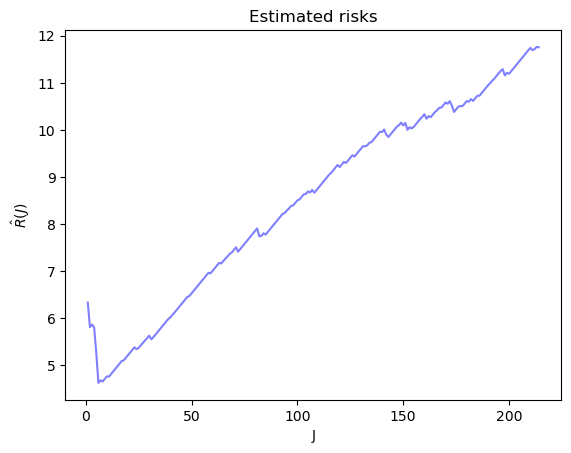

In [12]:
ax = plt.gca()
coeffs = compute_coeffs_cosine(X, Y)
plot_risks(coeffs, ax)

In [13]:
def compute_phis(n):
    """
        Compute the first n cosine basis functions.
    """
    return lambda x: np.array([np.sqrt(2) * np.cos(np.pi * j * x) for j in range(n)])

In [14]:
def compute_r_J(coeffs):
    """
        Compute the regression function r and the corresponding
        J which minimizes risk.
        coeffs: numpy array of floats representing the
            coefficients of a regression function.    
    """
    risks = compute_risks(coeffs)
    J = np.argmin(risks)
    phis = compute_phis(J)
    
    def r(x):
        output = phis(x)
        return np.dot(coeffs[:J], output)

    return r, J

In [15]:
def compute_a(n):
    """
        Compute the function a in the definition of the confidence
        band for regression with respect to the cosine basis.
    """
    phis = compute_phis(n)
    return lambda x: np.linalg.norm(phis(x))

In [16]:
def plot_conf_band_cosine(X, Y, ax, alpha=0.05):
    """
        Plot a a-alpha confidence band for the cosine
        regression of Y on X.
        X, Y: numpy arrays of floats with X lying in [0,1]
        ax: the axes on which to plot
        alpha: the parameter for the confidence band
    """
    
    n = len(X)    
    coeffs = compute_coeffs_cosine(X, Y)
    r, J = compute_r_J(coeffs)
    sigma2 = compute_sigma2_cosine(coeffs)
    a = compute_a(J)
    chi_J_a = chi.ppf(1-alpha, df=J)
    
    # Compute the functions l and u as bounds for the confidence band
    c = lambda x: a(x) * np.sqrt(sigma2) * chi_J_a / np.sqrt(n)
    l = lambda x: r(x) - c(x)
    u = lambda x: r(x) + c(x)

    x = np.linspace(0, 1, 1000)
    R = list(map(r, x))
    U = list(map(u, x))
    L = list(map(l, x))
    
    ax.scatter(X, Y, color='blue', alpha=0.5)
    ax.plot(x, R, color='black', alpha=0.8)
    ax.plot(x, U, color='green', alpha=0.8)
    ax.plot(x, L, color='orange', alpha=0.8)
    ax.set_xlabel(r'$X$')
    ax.set_ylabel(r'$Y$')
    ax.set_title('Confidence band for cosine basis regression')

Finally we plot the confidence band.

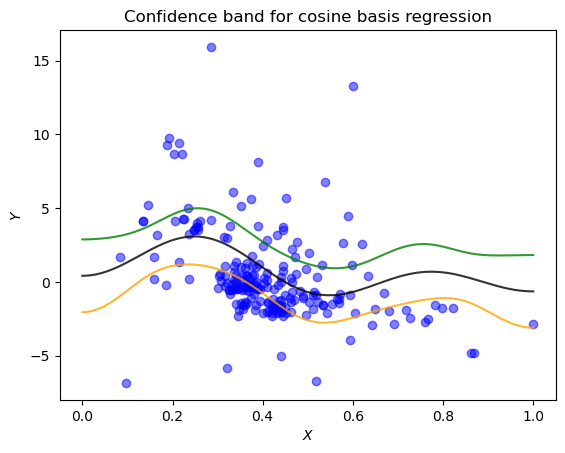

In [17]:
ax = plt.gca()
plot_conf_band_cosine(X, Y, ax)

# Part (b)

Again we'll define a bunch of functions to do the work for us.

In [18]:
def phi(x):
    """
        The father Haar wavelet
    """
    if 0 <= x and x < 1:
        return 1
    else:
        return 0

In [19]:
def psi_mother(x):
    """
        The mother Haar wavelet
    """
    if 0 <= x and x <= 1/2:
        return -1
    elif 1/2 < x <= 1:
        return 1
    else:
        return 0

In [20]:
def psi(j, k):
    """
        Return the function psi_{j,k} in the Haar wavelet basis
    """
    return lambda x: 2**(j/2) * psi_mother(2**j * x - k)

In [21]:
def haar_wave_reg(X, Y):
    """
        Perform Haar wavelet regression of Y on X.
        X, Y: numpy arrays of floats with X lying in [0,1]
        return: f, the Haar wavelet regression function
    """
    
    n = len(X)
    J = int(np.log2(n)) + 1
    
    alpha = (np.array(list(map(phi, X))) * Y).mean()

    D = np.zeros(2**J - 1)
    for j in range(J):
        for k in range(2**j):
            psijk = psi(j, k)
            D[2**j + k - 1] = (np.array(list(map(psijk, X))) * Y).mean()
    
    # Estimate sigma and apply universal thresholding to D
    D_sub = D[2**(J-1):]
    sigma = np.sqrt(n) * np.median(np.abs(D_sub)) / 0.6745
    beta = D * (np.abs(D) > sigma * np.sqrt(2 * np.log(n) / n))
    
    psis = [psi(j,k) for j in range(J) for k in range(2**j)]
    
    # Compute the regression function
    def f(x):
        wavelet_output = np.array([psi(x) for psi in psis])
        return alpha * phi(x) + np.dot(beta, wavelet_output)
    
    return f

In [24]:
def plot_haar_wave_reg(X, Y, ax):
    """
        Plot X, Y and the Haar wavelet regression function
        on the axes ax.
        X, Y: numpy arrays of floats with X lying in [0,1]
        ax: the axes on which to plot
    """
    f = haar_wave_reg(X, Y)
    x = np.linspace(0,1,10000)
    y = list(map(f, x))
    
    ax.scatter(X, Y, color='blue', alpha=0.5)
    ax.plot(x, y, color='green', alpha=0.8)
    ax.set_xlabel(r'$X$')
    ax.set_ylabel(r'$Y$')
    ax.set_title('Haar wavelet regression')

Here's the plot of the Haar wavelet regression function.

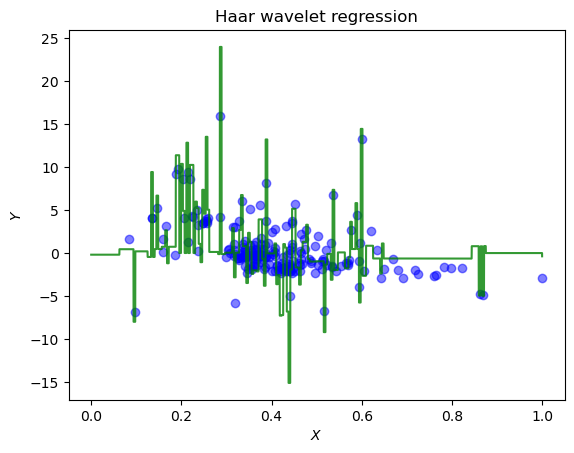

In [25]:
ax = plt.gca()
plot_haar_wave_reg(X, Y, ax)